# Package Inport

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import surpyval as surv
from scipy.stats import weibull_min
import lifelines as ll

# set the seed
seed = 24836
np.random.seed(seed)
rng = np.random.default_rng(seed)  # set the seed for the PyMC

In [2]:
"""
PySurvMC is a self-developed package for Baysian survival analysis using MCMC. 
The package is built on top of PyMC which provides a simple interface for fitting survival models using MCMC
You can install the package using the following command: pip install PySurvMC
The source code is available at:https://github.com/yueht23/PySurvMC
"""
from PySurvMC import WeibullPH as WeibullPH_MCMC

# Simulation study
## Non-censored Data

In [3]:
# simulation setting
N = 100  # number of data points
p = 1  # number of features
cen_prob = [0, 1, 0, 0]  # censoring probability of Left,Observed,Right,Interval

# true parameter for the base hazard
scale = 2
shape = 5
# true coefficient
coeff = np.arange(1, p + 1, 1)

# design matrix is binary as we want to visualize the survival function for different levels of the covariate
Z = np.random.binomial(1, 0.5, size=(N, p))
# censoring indicator
c = np.random.choice([-1, 0, 1, 2], size=N, p=cen_prob)

# generate the time to event data
# as there is no censoring, the observed time is the same as the true time
T_obs = weibull_min.rvs(c=shape, scale=scale * np.exp(-Z @ coeff) ** (1 / shape))

### Maximum Likelihood Estimation

In [4]:
weiph_mle = surv.regression.WeibullPH.fit(x=T_obs, c=c, Z=Z)
print(weiph_mle)
# as you can see, the MLE estimated coefficient and the base hazard parameter are close to the true value

Parametric Regression SurPyval Model
Kind                : Proportional Hazard
Distribution        : Weibull
Regression Model    : Log Linear (Exponential)
Fitted by           : MLE
Distribution        :
     alpha: 2.067391564080841
      beta: 5.124709455293433
Regression Model    :
    beta_0: 1.2024124873944368


In [5]:
# surpyval does not provide the summary method, so we need to extract the parameters manually
scale_mle = weiph_mle.params[0]
shape_mle = weiph_mle.params[1]
coeff_mle = weiph_mle.params[2:]
print(f"True Scale: {scale}, MLE Scale: {scale_mle}")
print(f"True Shape: {shape}, MLE Shape: {shape_mle}")
print(f"True Coefficients: {coeff}, MLE Coefficients: {coeff_mle}")

True Scale: 2, MLE Scale: 2.067391564080841
True Shape: 5, MLE Shape: 5.124709455293433
True Coefficients: [1], MLE Coefficients: [1.20241249]


### MCMC Estimation

In [6]:
# set a uninformative prior

priors = {"coeff": pm.Normal.dist(mu=0, sigma=100, shape=p),
          "shape": pm.HalfNormal.dist(sigma=100),
          "scale": pm.HalfNormal.dist(sigma=100)}
weiph_mcmc = WeibullPH_MCMC(lb=T_obs, ub=T_obs, event=c, covariates=Z, priors=priors)
weiph_mcmc.fit(draws=1000)
weiph_mcmc.summary()

,mean,sd,BCI_lb,BCI_ub
coeff[0],1.196,0.213,0.785,1.632
scale,2.072,0.058,1.964,2.192
scale_log__,0.728,0.028,0.675,0.785
shape,5.118,0.411,4.336,5.950
shape_log__,1.630,0.081,1.468,1.784


In [7]:
# as you can see, the MCMC estimated coefficient and the base hazard parameter are close to the true value
shape_map = weiph_mcmc.summary()["mean"]["shape"]
scale_map = weiph_mcmc.summary()["mean"]["scale"]
coeff_map = weiph_mcmc.summary()["mean"]["coeff[0]"]

print(f"True Scale: {scale}, MAP Scale: {scale_map}")
print(f"True Shape: {shape}, MAP Shape: {shape_map}")
print(f"True Coefficients: {coeff}, MAP Coefficients: {coeff_map}")

True Scale: 2, MAP Scale: 2.072
True Shape: 5, MAP Shape: 5.118
True Coefficients: [1], MAP Coefficients: 1.196


### Visualization

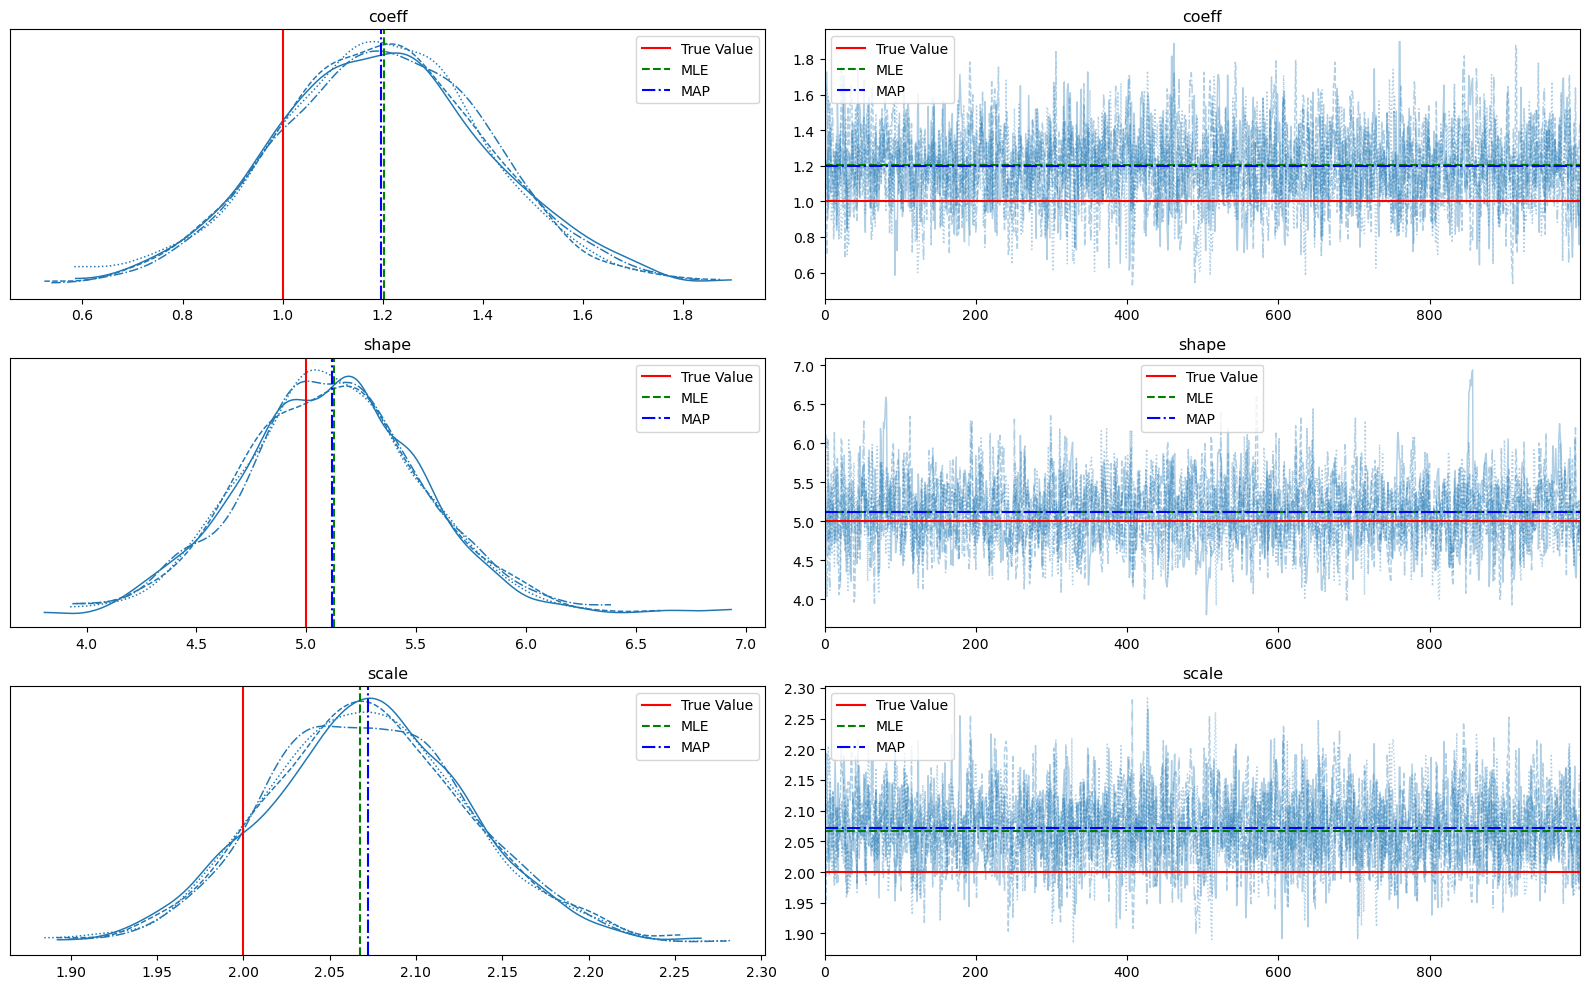

In [8]:
# plot the traceplot

# set the font size of the plot
plt.rcParams.update({"font.size": 10})

az.plot_trace(weiph_mcmc.trace, figsize=(16, 10), var_names=["coeff", "shape", "scale"])
# for coefficient
plt.gcf().get_axes()[0].axvline(x=coeff, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[0].axvline(x=coeff_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[0].axvline(x=coeff_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[0].legend()

plt.gcf().get_axes()[1].axhline(y=coeff, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[1].axhline(y=coeff_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[1].axhline(y=coeff_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[1].legend()

# for shape
plt.gcf().get_axes()[2].axvline(x=shape, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[2].axvline(x=shape_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[2].axvline(x=shape_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[2].legend()

plt.gcf().get_axes()[3].axhline(y=shape, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[3].axhline(y=shape_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[3].axhline(y=shape_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[3].legend()

# for scale
plt.gcf().get_axes()[4].axvline(x=scale, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[4].axvline(x=scale_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[4].axvline(x=scale_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[4].legend()

plt.gcf().get_axes()[5].axhline(y=scale, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[5].axhline(y=scale_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[5].axhline(y=scale_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[5].legend()

# save the plot with tidy layout
plt.tight_layout()
plt.savefig("figs/traceplot_simu_nocen.png")

plt.show()

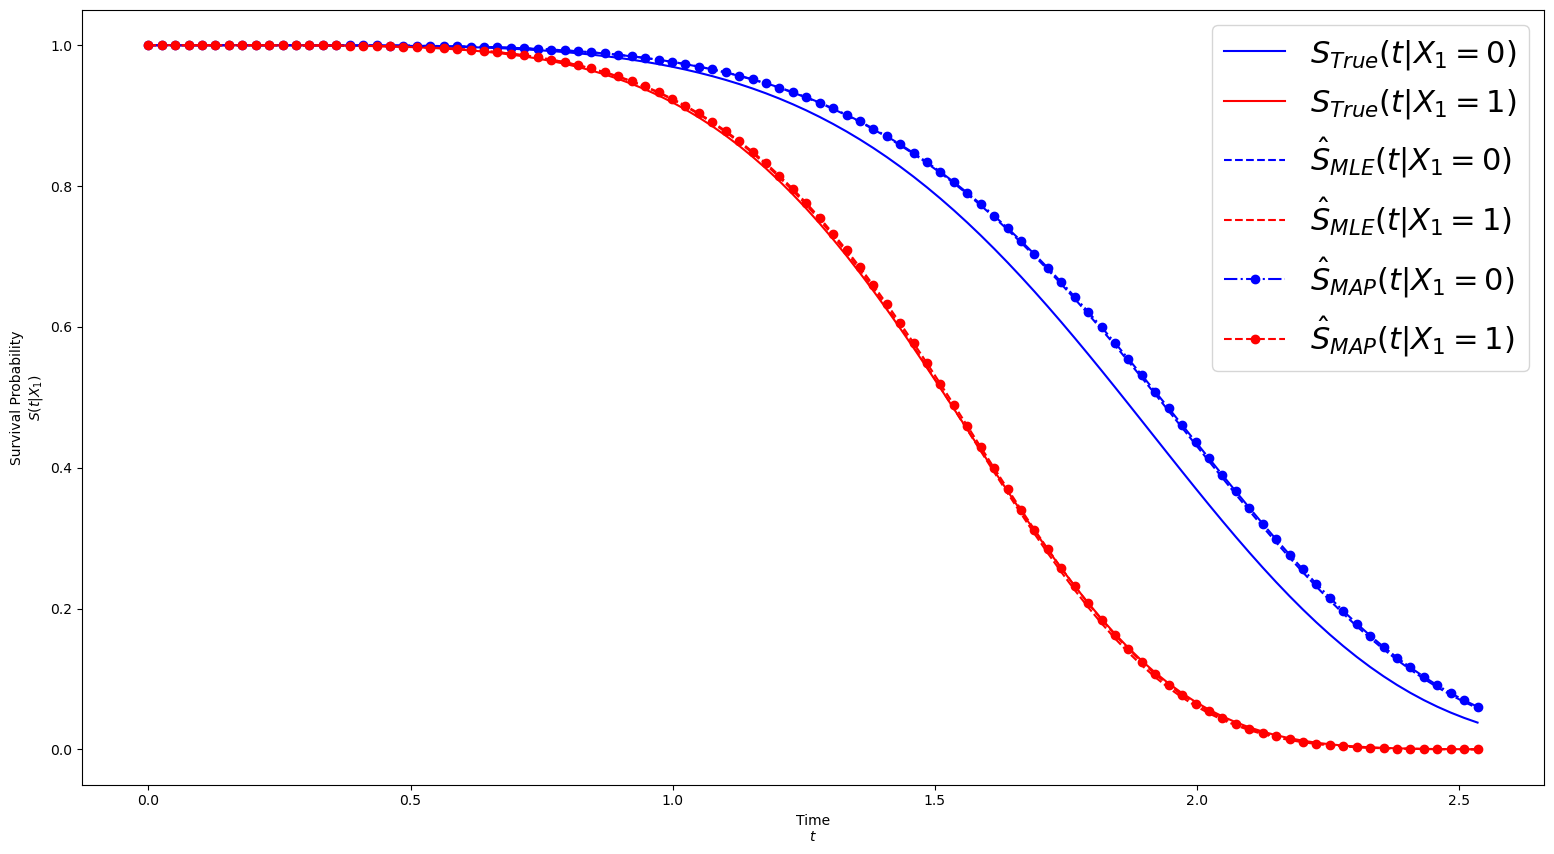

In [9]:
# create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# set the font size of the plot
plt.rcParams.update({"font.size": 22})

# # draw the true survival function
t = np.linspace(0, np.max(T_obs), 100)
ax.plot(t, weibull_min.sf(t, c=shape, scale=scale), label="$S_{True}(t|X_1=0)$", linestyle="-", color="blue")
ax.plot(t, weibull_min.sf(t, c=shape, scale=scale * np.exp(-coeff) ** (1 / shape)), label="$S_{True}(t|X_1=1)$",
        linestyle="-", color="red")

# draw the MLE survival function
ax.plot(t, weibull_min.sf(t, c=shape_mle, scale=scale_mle), label="$\hat{S}_{MLE}(t|X_1=0)$", linestyle="--",
        color="blue")
ax.plot(t, weibull_min.sf(t, c=shape_mle, scale=scale_mle * np.exp(-coeff_mle) ** (1 / shape_mle)),
        label="$\hat{S}_{MLE}(t|X_1=1)$", linestyle="--", color="red")

# draw the MCMC survival function
ax.plot(t, weibull_min.sf(t, c=shape_map, scale=scale_map), label="$\hat{S}_{MAP}(t|X_1=0)$", linestyle="-.",
        color="blue",
        marker="o")
ax.plot(t, weibull_min.sf(t, c=shape_map, scale=scale_map * np.exp(-coeff_map) ** (1 / shape_map)),
        label="$\hat{S}_{MAP}(t|X_1=1)$", linestyle="--", color="red", marker="o")

# # set the x-axis label
ax.set_xlabel("Time\n" + "$t$")

# # set the y-axis label
ax.set_ylabel("Survival Probability\n" + "$S(t|X_1)$")

# # set the title
plt.legend()
# show the plot

# set the font size of the plot
plt.rcParams.update({"font.size": 22})

# save the plot with tidy layout
plt.tight_layout()
plt.savefig("figs/survival_simu_nocen.png")

plt.show()

## Censored Data


In [10]:
# simulation setting
N = 100  # number of data points
p = 1  # number of features
cen_prob = [0.1, 0.7, 0.1, 0.1]  # censoring probability of Left,Observed,Right,Interval

# true parameter for the base hazard
scale = 2
shape = 5

# true coefficient
coeff = np.arange(1, p + 1, 1)

# design matrix is binary as we want to visualize the survival function for different levels of the covariate
Z = np.random.binomial(1, 0.5, size=(N, p))

# censoring indicator
c = np.random.choice([-1, 0, 1, 2], size=N, p=cen_prob)

# generate the time to event data
T_obs = weibull_min.rvs(c=shape, scale=scale * np.exp(-Z @ coeff) ** (1 / shape))

# as there is censoring, the observed time is different from the true time
ub = T_obs + np.random.uniform(0, T_obs / 5, size=N)
lb = T_obs - np.random.uniform(0, T_obs / 5, size=N)

T_obs = []

for i in range(N):
    # c=-1: left-censored, we only observe the lower bound
    if c[i] == -1:
        T_obs.append(lb[i])
    # c=0: observed, we observe the exact time
    elif c[i] == 0:
        T_obs.append(ub[i])
    # c=1: right-censored, we only observe the upper bound
    elif c[i] == 1:
        T_obs.append(ub[i])
    # c=2: interval-censored, we observe both the lower and upper bound
    elif c[i] == 2:
        T_obs.append([lb[i], ub[i]])

### Maximum Likelihood Estimation

In [11]:
weiph_mle = surv.regression.WeibullPH.fit(x=T_obs, c=c, Z=Z)
print(weiph_mle)

Parametric Regression SurPyval Model
Kind                : Proportional Hazard
Distribution        : Weibull
Regression Model    : Log Linear (Exponential)
Fitted by           : MLE
Distribution        :
     alpha: 2.1464966104247374
      beta: 4.0086885230554525
Regression Model    :
    beta_0: 0.5817879284083939


In [12]:
# as you can see, the MLE estimated coefficient and the base hazard parameter are NOT close to the true value
# as there is censoring in the data
scale_mle = weiph_mle.params[0]
shape_mle = weiph_mle.params[1]
coeff_mle = weiph_mle.params[2:]
print(f"True Scale: {scale}, MLE Scale: {scale_mle}")
print(f"True Shape: {shape}, MLE Shape: {shape_mle}")
print(f"True Coefficients: {coeff}, MLE Coefficients: {coeff_mle}")

True Scale: 2, MLE Scale: 2.1464966104247374
True Shape: 5, MLE Shape: 4.0086885230554525
True Coefficients: [1], MLE Coefficients: [0.58178793]


### MCMC Estimation

In [13]:
# set a uninformative prior
priors = {"coeff": pm.Normal.dist(mu=0, sigma=100, shape=p),
          "shape": pm.HalfNormal.dist(sigma=100),
          "scale": pm.HalfNormal.dist(sigma=100)}
# data preparation
lb = [_[0] if isinstance(_, list) else _ for _ in T_obs]
ub = [_[1] if isinstance(_, list) else _ for _ in T_obs]

weiph_mcmc = WeibullPH_MCMC(lb=lb, ub=ub, event=c, covariates=Z, priors=priors)
weiph_mcmc.fit(draws=1000)
weiph_mcmc.summary()

,mean,sd,BCI_lb,BCI_ub
coeff[0],0.759,0.257,0.277,1.272
scale,2.226,0.102,2.036,2.430
scale_log__,0.799,0.046,0.711,0.888
shape,4.253,0.393,3.512,5.054
shape_log__,1.443,0.093,1.266,1.629


In [14]:
# as you can see, the MCMC estimated coefficient and the base hazard parameter are also NOT close to the true value
shape_map = weiph_mcmc.summary()["mean"]["shape"]
scale_map = weiph_mcmc.summary()["mean"]["scale"]
coeff_map = weiph_mcmc.summary()["mean"]["coeff[0]"]

print(f"True Scale: {scale}, MAP Scale: {scale_map}")
print(f"True Shape: {shape}, MAP Shape: {shape_map}")
print(f"True Coefficients: {coeff}, MAP Coefficients: {coeff_map}")

True Scale: 2, MAP Scale: 2.226
True Shape: 5, MAP Shape: 4.253
True Coefficients: [1], MAP Coefficients: 0.759


### Visualization

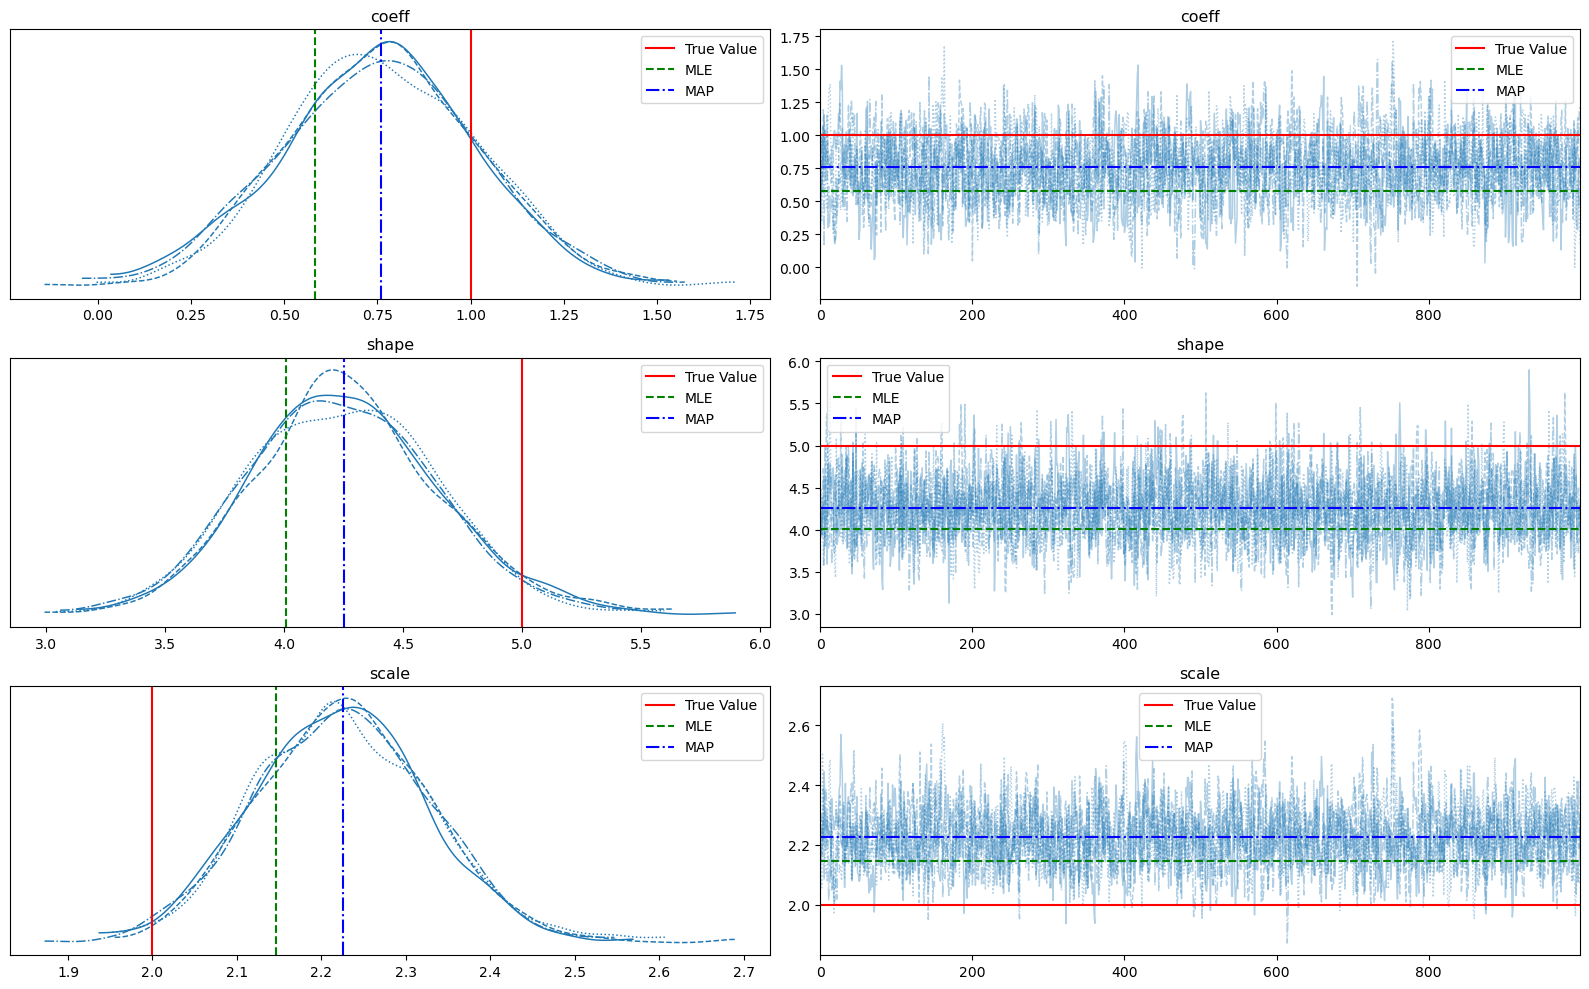

In [15]:
# plot the traceplot

# set the font size of the plot
plt.rcParams.update({"font.size": 10})

az.plot_trace(weiph_mcmc.trace, figsize=(16, 10), var_names=["coeff", "shape", "scale"])
# for coefficient
plt.gcf().get_axes()[0].axvline(x=coeff, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[0].axvline(x=coeff_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[0].axvline(x=coeff_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[0].legend()

plt.gcf().get_axes()[1].axhline(y=coeff, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[1].axhline(y=coeff_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[1].axhline(y=coeff_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[1].legend()

# for shape
plt.gcf().get_axes()[2].axvline(x=shape, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[2].axvline(x=shape_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[2].axvline(x=shape_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[2].legend()

plt.gcf().get_axes()[3].axhline(y=shape, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[3].axhline(y=shape_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[3].axhline(y=shape_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[3].legend()

# for scale
plt.gcf().get_axes()[4].axvline(x=scale, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[4].axvline(x=scale_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[4].axvline(x=scale_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[4].legend()

plt.gcf().get_axes()[5].axhline(y=scale, color="r", linestyle="-", label="True Value")
plt.gcf().get_axes()[5].axhline(y=scale_mle, color="g", linestyle="--", label="MLE")
plt.gcf().get_axes()[5].axhline(y=scale_map, color="b", linestyle="-.", label="MAP")
plt.gcf().get_axes()[5].legend()

# save the plot with tidy layout
plt.tight_layout()
plt.savefig("figs/traceplot_simu_cen.png")

# show the plot
plt.show()

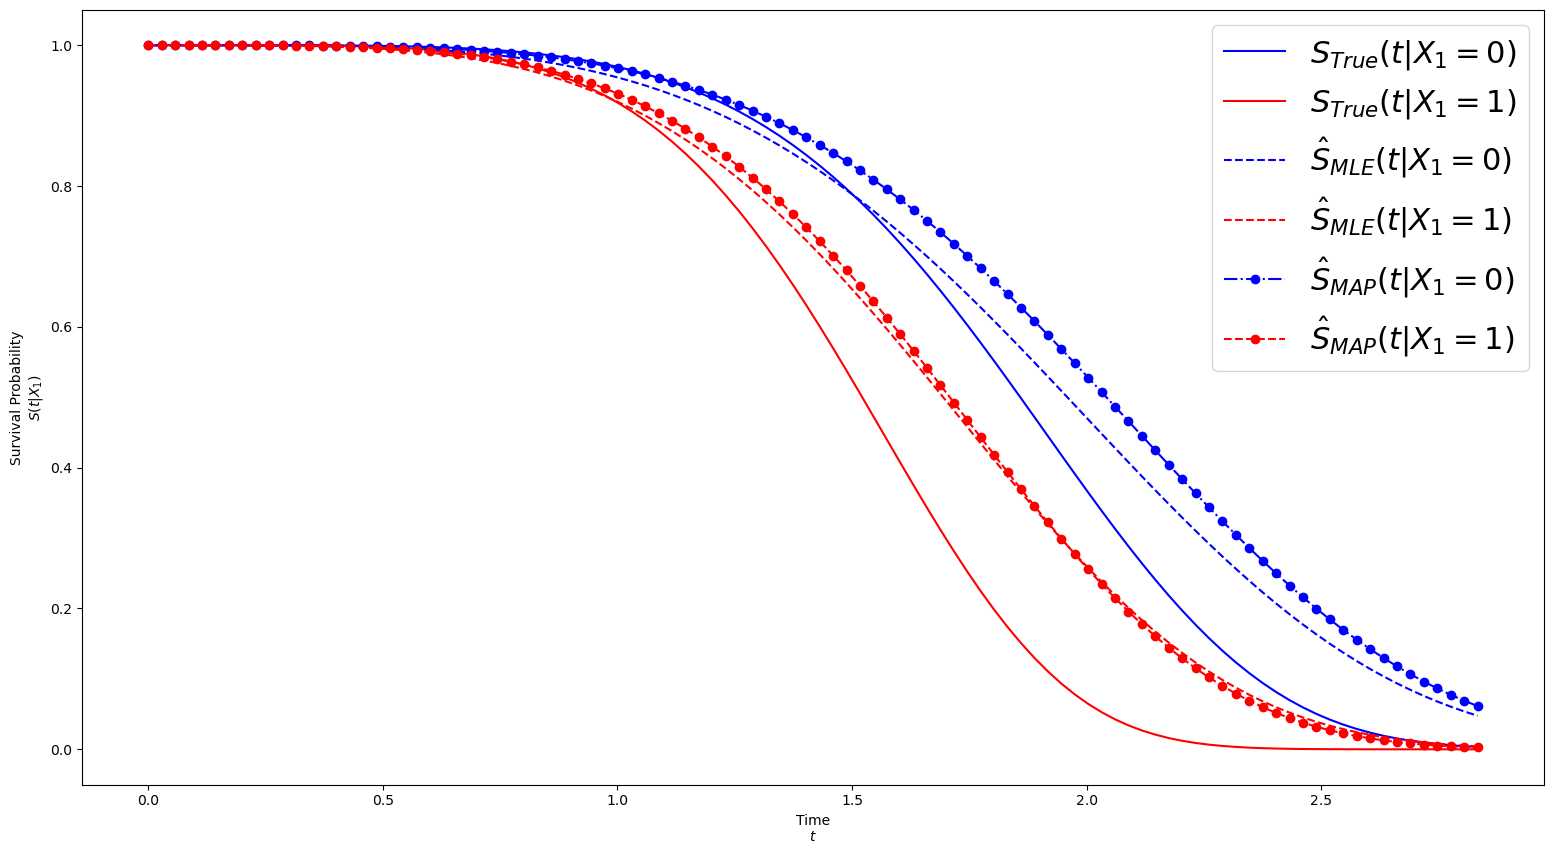

In [16]:
# create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(16, 9))

# set the font size of the plot
plt.rcParams.update({"font.size": 22})

# # draw the true survival function
t = np.linspace(0, np.max(ub), 100)
ax.plot(t, weibull_min.sf(t, c=shape, scale=scale), label="$S_{True}(t|X_1=0)$", linestyle="-", color="blue")
ax.plot(t, weibull_min.sf(t, c=shape, scale=scale * np.exp(-coeff) ** (1 / shape)), label="$S_{True}(t|X_1=1)$",
        linestyle="-", color="red")

# draw the MLE survival function
ax.plot(t, weibull_min.sf(t, c=shape_mle, scale=scale_mle), label="$\hat{S}_{MLE}(t|X_1=0)$", linestyle="--",
        color="blue")
ax.plot(t, weibull_min.sf(t, c=shape_mle, scale=scale_mle * np.exp(-coeff_mle) ** (1 / shape_mle)),
        label="$\hat{S}_{MLE}(t|X_1=1)$", linestyle="--", color="red")

# draw the MCMC survival function
ax.plot(t, weibull_min.sf(t, c=shape_map, scale=scale_map), label="$\hat{S}_{MAP}(t|X_1=0)$", linestyle="-.",
        color="blue",
        marker="o")
ax.plot(t, weibull_min.sf(t, c=shape_map, scale=scale_map * np.exp(-coeff_map) ** (1 / shape_map)),
        label="$\hat{S}_{MAP}(t|X_1=1)$", linestyle="--", color="red", marker="o")

# # set the x-axis label
ax.set_xlabel("Time\n" + "$t$")

# # set the y-axis label
ax.set_ylabel("Survival Probability\n" + "$S(t|X_1)$")

# # set the title
plt.legend()

# save the plot with tidy layout
plt.tight_layout()
plt.savefig("figs/survival_simu_cen.png")

# show the plot
plt.show()

# Real Case

In this section, we will use the real data to demonstrate the usage of the package. The real data is from the "Loprinzi CL. Laurie JA. Wieand HS. Krook JE. Novotny PJ. Kugler JW. Bartel J. Law M. Bateman M. Klatt NE. et al. Prospective evaluation of prognostic variables from patient-completed questionnaires. North Central Cancer Treatment Group. Journal of Clinical Oncology. 12(3):601-7, 1994." which give the survival time of patients with advanced lung cancer. 



Here, we want investigate the differences in all-cause mortality between men and women diagnosed with advanced lung cancer,227 participants aged 39 to 82 were monitored up to three years until time of death. The participants were segmented into three groups according to their ECOG performance score: Asymptomatic, symptomatic but completely Ambulatory, and Bedridden at least part of the day. Participants’ age and gender were captured as possible controlling covariates, but will not be used here since a KM analysis is only able to compare the distributions among levels of a single factor. 


## Data Loading

- time: Survival time in days
- status: censoring status 1=censored, 2=dead
- age: Age in years
- sex: Male=1 Female=2
- ph.ecog: ECOG performance score (0=good 5=dead)
    - 0: Asymptomatic
    - 1: Ambulatory
    - 2,3,4,5: Bedridden

In [17]:
url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/lung.csv"
data = pd.read_csv(url)
# select the columns of interest
data = data.loc[:, ["time", "status", "age", "sex", "ph.ecog"]]
# drop the missing values
data = data.dropna()
data

,time,status,age,sex,ph.ecog
0,306,1,74,1,1.0
1,455,1,68,1,0.0
2,1010,0,56,1,0.0
3,210,1,57,1,1.0
4,883,1,60,1,0.0
...,...,...,...,...,...
223,188,0,77,1,1.0
224,191,0,39,1,0.0
225,105,0,75,2,2.0
226,174,0,66,1,1.0


## Data Preprocessing

In [18]:
# here the status is the censoring indicator
# 0 is alive i.e. censored, 1 is dead i.e. observed
# Hence, we need to change the status to event as we defined in the package 0 is observed and 1 is censored
data["event"] = 1 - data["status"]

# Convert the sex to Female column
data["Female"] = data["sex"].map({2: 1, 1: 0})

# Convert the ph.ecog to Asymptomatic, Ambulatory, Bedridden
data["Asymptomatic"] = (data["ph.ecog"] == 0).astype(int)
data["Ambulatory"] = (data["ph.ecog"] == 1).astype(int)
data["Bedridden"] = (data["ph.ecog"] > 1).astype(int)

# cut the age into 3 groups (38,55], (55,65], (65,83]
data["(38,55]"] = (data["age"] <= 55).astype(int)
data["(55,65]"] = ((data["age"] > 55) & (data["age"] <= 65)).astype(int)
data["(65,83]"] = (data["age"] > 65).astype(int)

# drop the columns that are not needed
data = data.drop(columns=["sex", "ph.ecog", "age", "status"])

data

,time,event,Female,Asymptomatic,Ambulatory,Bedridden,"(38,55]","(55,65]","(65,83]"
0,306,0,0,0,1,0,0,0,1
1,455,0,0,1,0,0,0,0,1
2,1010,1,0,1,0,0,0,1,0
3,210,0,0,0,1,0,0,1,0
4,883,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
223,188,1,0,0,1,0,0,0,1
224,191,1,0,1,0,0,1,0,0
225,105,1,1,0,0,1,0,0,1
226,174,1,0,0,1,0,0,0,1


## Maximum Likelihood Estimation

In [19]:
# fit the model
# SET the Asymptomatic as the reference level
# SET the age group (0,55] as the reference level
covariates = ["Female", "Ambulatory", "Bedridden", "(55,65]", "(65,83]"]

weiph_mle = surv.regression.WeibullPH.fit(x=data["time"], c=data["event"], Z=data[covariates])
print(weiph_mle)

Parametric Regression SurPyval Model
Kind                : Proportional Hazard
Distribution        : Weibull
Regression Model    : Log Linear (Exponential)
Fitted by           : MLE
Distribution        :
     alpha: 484.00758836906476
      beta: 1.3695412083896445
Regression Model    :
    beta_0: -0.5633892600555171
    beta_1: 0.37508809659427267
    beta_2: 0.9224297475515505
    beta_3: -0.06562134754771286
    beta_4: 0.11277573293047143


In [20]:
# we zip the covariates and the coefficients together
coefficients_mle = dict(zip(["scale", "shape"] + covariates, weiph_mle.params))
coefficients_mle

{'scale': 484.00758836906476,
 'shape': 1.3695412083896445,
 'Female': -0.5633892600555171,
 'Ambulatory': 0.37508809659427267,
 'Bedridden': 0.9224297475515505,
 '(55,65]': -0.06562134754771286,
 '(65,83]': 0.11277573293047143}

## MCMC Estimation

In [21]:
# set a uninformative prior
priors = {"coeff": pm.Normal.dist(mu=0, sigma=100, shape=len(covariates)),
          "shape": pm.HalfNormal.dist(sigma=100),
          "scale": pm.HalfNormal.dist(sigma=100)}

weiph_mcmc = WeibullPH_MCMC(lb=data["time"].values,
                            ub=data["time"].values,
                            event=data["event"].values,
                            covariates=data[covariates],
                            priors=priors)
weiph_mcmc.fit(draws=10000, random_seed=seed, cores=8)

In [23]:
summary = az.summary(weiph_mcmc.trace, var_names=["coeff"], hdi_prob=0.95, round_to=2)
# summary.to_csv("figs/mcmccoeff_summary.csv")
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff[0],-1.20,0.32,-1.80,-0.63,0.07,0.05,23.65,89.53,1.12
coeff[1],0.27,0.56,-1.24,0.99,0.25,0.19,7.63,11.04,1.46
coeff[2],0.81,0.53,-0.58,1.51,0.23,0.17,7.86,11.01,1.43
coeff[3],-0.76,0.41,-1.76,-0.14,0.17,0.13,8.86,11.19,1.36
coeff[4],-0.20,0.45,-1.32,0.43,0.19,0.15,8.60,12.12,1.38


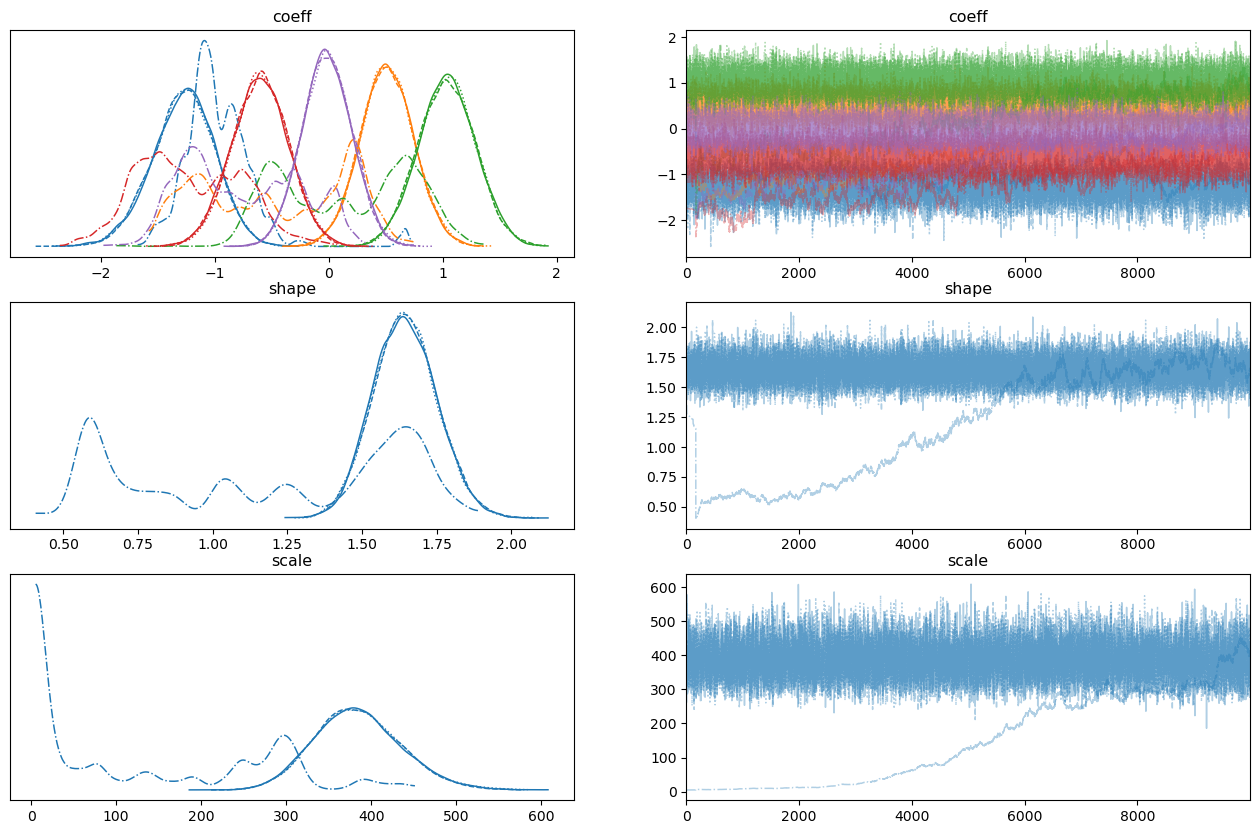

In [24]:
weiph_mcmc.plot_trace(var_names=["coeff", "shape", "scale"], figsize=(16, 10))
plt.show()

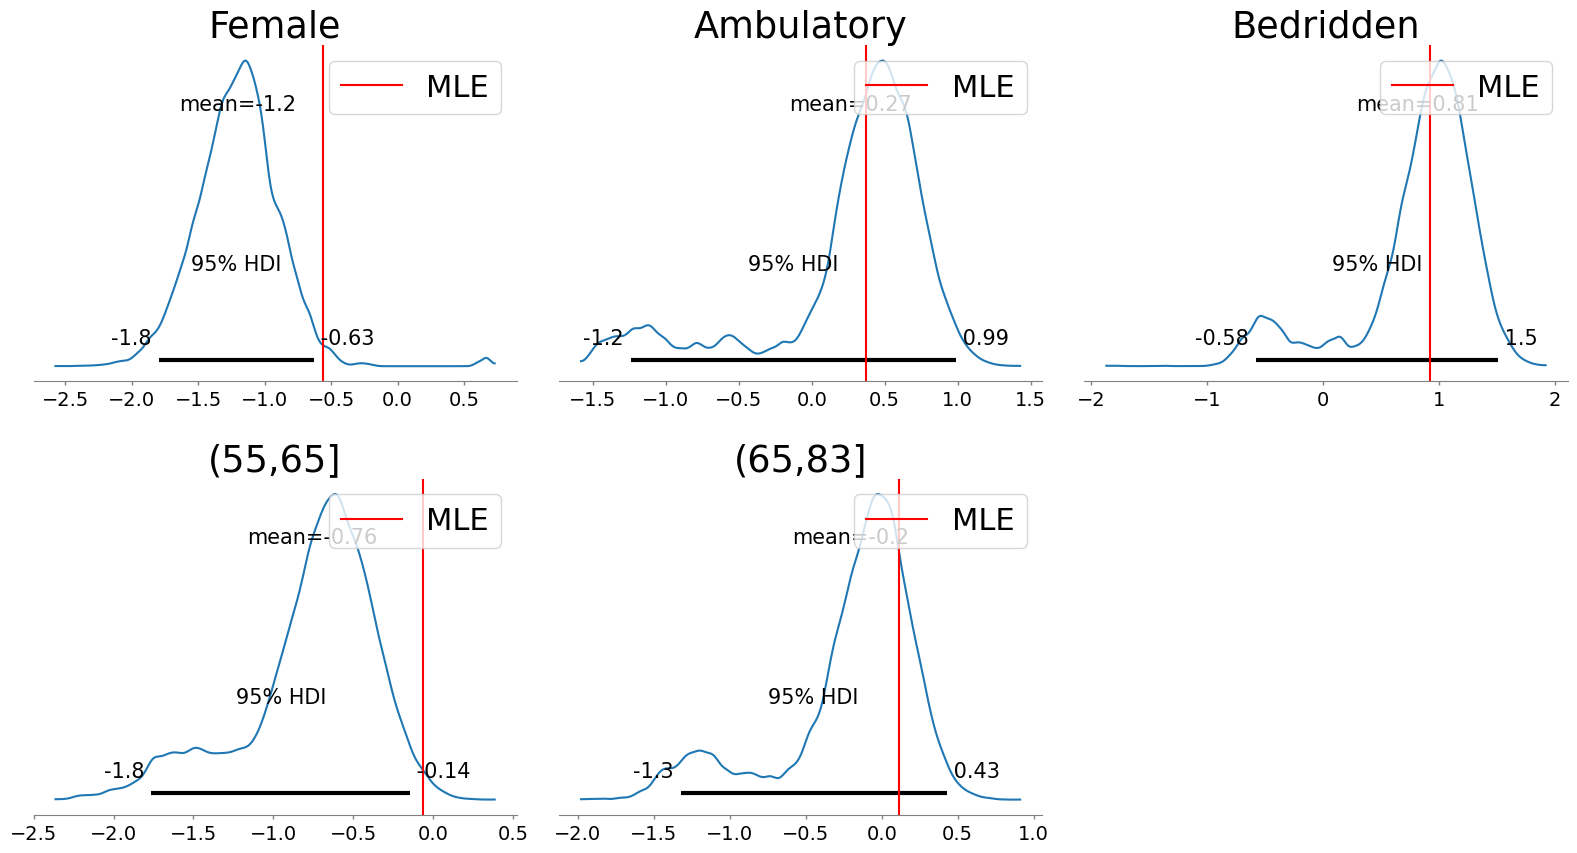

In [25]:
weiph_mcmc.plot_posterior(var_names=["coeff"], figsize=(16, 9), hdi_prob=0.95)

plt.gcf().get_axes()[0].axvline(x=coefficients_mle["Female"], color="r", linestyle="-", label="MLE")
plt.gcf().get_axes()[0].set_title("Female")
plt.gcf().get_axes()[0].legend(loc="upper right")

plt.gcf().get_axes()[1].axvline(x=coefficients_mle["Ambulatory"], color="r", linestyle="-", label="MLE")
plt.gcf().get_axes()[1].set_title("Ambulatory")
plt.gcf().get_axes()[1].legend(loc="upper right")

plt.gcf().get_axes()[2].axvline(x=coefficients_mle["Bedridden"], color="r", linestyle="-", label="MLE")
plt.gcf().get_axes()[2].set_title("Bedridden")
plt.gcf().get_axes()[2].legend(loc="upper right")

plt.gcf().get_axes()[3].axvline(x=coefficients_mle["(55,65]"], color="r", linestyle="-", label="MLE")
plt.gcf().get_axes()[3].set_title("(55,65]")
plt.gcf().get_axes()[3].legend(loc="upper right")

plt.gcf().get_axes()[4].axvline(x=coefficients_mle["(65,83]"], color="r", linestyle="-", label="MLE")
plt.gcf().get_axes()[4].set_title("(65,83]")
plt.gcf().get_axes()[4].legend(loc="upper right")

plt.tight_layout()
# set the font size of the plot
plt.rcParams.update({"font.size": 14})

plt.savefig("figs/posterior_real.png")

plt.show()



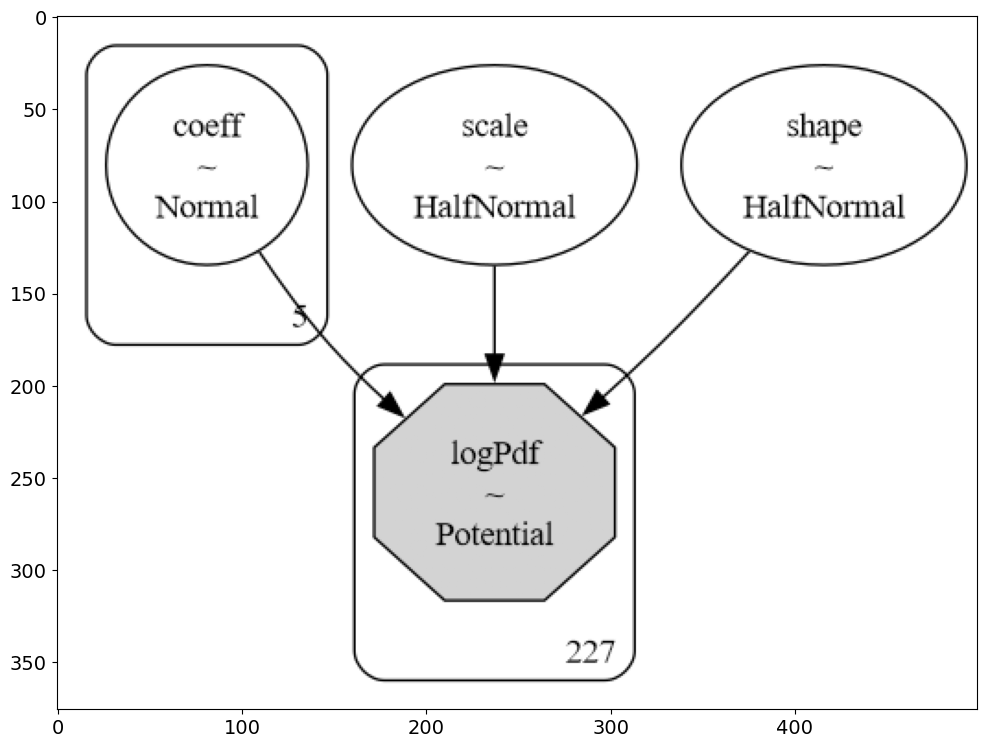

In [36]:
svg = pm.model_to_graphviz(weiph_mcmc.model)
# save the graph as a png file
svg.render("figs/graph_real", format="png")

# show the png saved
plt.figure(figsize=(16, 9))
plt.imshow(plt.imread("figs/graph_real.png"))